In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np

from numpy import genfromtxt
from scipy import stats
from sklearn.datasets import load_boston

In [31]:
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

def read_boston_data():
    boston = load_boston()
    features = np.array(boston.data)
    labels = np.array(boston.target)
    return features, labels

# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

## 찾은거 요약
- [Numpy ndarray 연산](http://yujuwon.tistory.com/entry/Numpy-ndarray-%EC%97%B0%EC%82%B0)
- [numpy.array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html)
- [numpy.ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) ndarray is N-demension array
- [numpy.ndarray.shape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)
- [numpy describe data](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.describe.html)
- [numpy.random.rand](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html)

In [32]:
features,labels = read_boston_data()
print features.shape, labels.shape
print stats.describe(features).variance
#[  7.39046710e+01   5.43936814e+02   4.70644425e+01   6.45129730e-02
#   1.34276357e-02   4.93670850e-01   7.92358399e+02   4.43401514e+00
#   7.58163660e+01   2.84047595e+04   4.68698912e+00   8.33475226e+03
#   5.09947595e+01]

normalized_features = feature_normalize(features)
print stats.describe(normalized_features).variance
# 확실히 위의 features에 비해서, variance가 1에 근접함
#[ 1.0019802  1.0019802  1.0019802  1.0019802  1.0019802  1.0019802
#  1.0019802  1.0019802  1.0019802  1.0019802  1.0019802  1.0019802
#  1.0019802]

f, l = append_bias_reshape(normalized_features,labels)
# bias variable이 추가됨
print f.shape
n_dim = f.shape[1] # variable count


(506, 13) (506,)
[  7.39046710e+01   5.43936814e+02   4.70644425e+01   6.45129730e-02
   1.34276357e-02   4.93670850e-01   7.92358399e+02   4.43401514e+00
   7.58163660e+01   2.84047595e+04   4.68698912e+00   8.33475226e+03
   5.09947595e+01]
[ 1.0019802  1.0019802  1.0019802  1.0019802  1.0019802  1.0019802
  1.0019802  1.0019802  1.0019802  1.0019802  1.0019802  1.0019802
  1.0019802]
(506, 14)


In [8]:
# rand는 [0,1)의 array를 만들어냄 따라서 0.8보다 작은 행을 true로 만들어 train data set으로 선택하려는 것
# 80%를 의미하는 지는 rand 내부를 봐야함
rnd_indices = np.random.rand(len(f)) < 0.80
print rnd_indices.shape

train_x = f[rnd_indices]
train_y = l[rnd_indices]
test_x = f[~rnd_indices]
test_y = l[~rnd_indices]

(506,)


In [9]:
learning_rate = 0.1
training_epochs = 10000
cost_history = np.empty(shape=[1],dtype=float)

X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.ones([n_dim,1]))

init = tf.global_variables_initializer()

In [10]:
y_ = tf.matmul(X, W)
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [40]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))

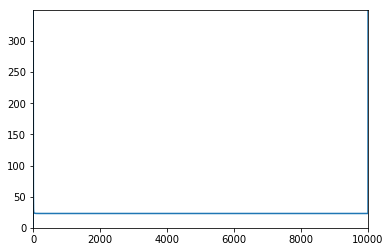

In [41]:
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 18.5305


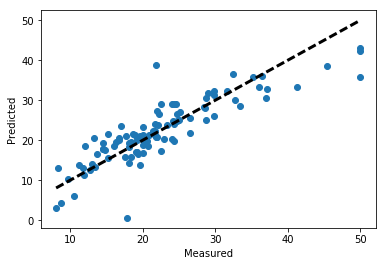

In [42]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [44]:
col_desc = ["0. Bias","1. CRIM: per capita crime rate by town ",
"2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. ",
"3. INDUS: proportion of non-retail business acres per town ",
"4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) ",
"5. NOX: nitric oxides concentration (parts per 10 million) ",
"6. RM: average number of rooms per dwelling ",
"7. AGE: proportion of owner-occupied units built prior to 1940 ",
"8. DIS: weighted distances to five Boston employment centres ",
"9. RAD: index of accessibility to radial highways ",
"10. TAX: full-value property-tax rate per $10,000 ",
"11. PTRATIO: pupil-teacher ratio by town ",
"12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town ",
"13. LSTAT: % lower status of the population "]

print np.c_[sess.run(W), col_desc] 

[['22.5410957336' '0. Bias']
 ['-1.11253035069' '1. CRIM: per capita crime rate by town ']
 ['1.16822910309'
  '2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. ']
 ['0.103921040893'
  '3. INDUS: proportion of non-retail business acres per town ']
 ['0.804947674274'
  '4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) ']
 ['-1.65389966965'
  '5. NOX: nitric oxides concentration (parts per 10 million) ']
 ['2.62107539177' '6. RM: average number of rooms per dwelling ']
 ['-0.0379169210792'
  '7. AGE: proportion of owner-occupied units built prior to 1940 ']
 ['-3.14623165131'
  '8. DIS: weighted distances to five Boston employment centres ']
 ['2.87819242477' '9. RAD: index of accessibility to radial highways ']
 ['-2.08802080154' '10. TAX: full-value property-tax rate per $10,000 ']
 ['-2.01355981827' '11. PTRATIO: pupil-teacher ratio by town ']
 ['1.02733182907'
  '12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

In [38]:
sess.close()